In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

# Load cleaned and encoded dataset (consistent path)
df_encoded = pd.read_csv('../data/cleaned_credit_data.csv')
print(f"Total rows in cleaned dataset: {df_encoded.shape[0]:,}")

# Sample 500,000 rows for fair comparison across models
df_sample = df_encoded.sample(n=500_000, random_state=42)

# Features/target
X = df_sample.drop('default', axis=1)
y = df_sample['default']


Total rows in cleaned dataset: 1,345,310


In [4]:
# XGBoost 3.x disallows '[', ']', '<' in feature names
def clean_cols(index):
    idx = pd.Index(index).astype(str)
    idx = (idx.str.replace(r'\[', '', regex=True)
              .str.replace(r'\]', '', regex=True)
              .str.replace('<', 'LT', regex=False)
              .str.replace('>', 'GT', regex=False)
              .str.replace(r'\s+', '_', regex=True))
    return idx

X.columns = clean_cols(X.columns)


In [5]:
# 80/20 split, stratified, consistent with previous notebooks
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((400000, 867), (100000, 867))

In [6]:
# Take 50,000 rows from the training split for fast tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=50_000, stratify=y_train, random_state=42
)

# Class imbalance weight around the actual ratio
neg, pos = np.bincount(y_tune)
base_spw = neg / pos
print(f"scale_pos_weight baseline: {base_spw:.2f}")

# Parameter distributions (focused, fast)
param_dist = {
    'n_estimators':        [300, 500, 700],
    'max_depth':           [4, 5, 6],
    'learning_rate':       [0.03, 0.05, 0.1],
    'min_child_weight':    [1, 3, 5],
    'subsample':           [0.6, 0.8, 1.0],
    'colsample_bytree':    [0.6, 0.8, 1.0],
    'gamma':               [0.0, 0.1, 0.2],
    'scale_pos_weight':    [base_spw * f for f in [0.8, 1.0, 1.2]]
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,              # keep it fast
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

t0 = time.time()
rs.fit(X_tune, y_tune)
tuning_time = time.time() - t0

print("Best params:", rs.best_params_)
print(f"Best CV AUC: {rs.best_score_:.4f}")
print(f"Tuning time: {tuning_time:.2f}s")
best_params = rs.best_params_


scale_pos_weight baseline: 4.02
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=4.822282445046673, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=4.822282445046673, subsample=0.8; total time=  13.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=4.822282445046673, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, scale_pos_weight=4.822282445046673, subsample=1.0; total time=  15.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=500, scale_pos_weight=4.822282445046673, subsample=1.0; total time=

In [7]:
xgb_final = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
xgb_final.fit(X_train, y_train)
train_time = time.time() - t0
print(f"Training time (500k train rows): {train_time:.2f}s")


Training time (500k train rows): 24.85s


In [8]:
y_proba = xgb_final.predict_proba(X_test)[:, 1]
y_pred_05 = (y_proba >= 0.5).astype(int)

print("Confusion Matrix (threshold=0.5):")
print(confusion_matrix(y_test, y_pred_05))

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_test, y_pred_05))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR  AUC: {pr_auc:.3f}")


Confusion Matrix (threshold=0.5):
[[52039 28035]
 [ 6434 13492]]

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.89      0.65      0.75     80074
           1       0.32      0.68      0.44     19926

    accuracy                           0.66    100000
   macro avg       0.61      0.66      0.60    100000
weighted avg       0.78      0.66      0.69    100000

ROC AUC: 0.725
PR  AUC: 0.397


In [9]:
prec, rec, thr = precision_recall_curve(y_test, y_proba)
# compute F1 for each threshold (ignore final point without threshold)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1[:-1])  # align with thresholds length
best_thr = thr[best_idx]
print(f"Best threshold by F1: {best_thr:.3f} | Precision={prec[best_idx]:.3f}, Recall={rec[best_idx]:.3f}, F1={f1[best_idx]:.3f}")

# Apply best threshold
y_pred_best = (y_proba >= best_thr).astype(int)

print("\nConfusion Matrix (best F1 threshold):")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report (best F1 threshold):")
print(classification_report(y_test, y_pred_best))


Best threshold by F1: 0.534 | Precision=0.345, Recall=0.615, F1=0.442

Confusion Matrix (best F1 threshold):
[[56796 23278]
 [ 7673 12253]]

Classification Report (best F1 threshold):
              precision    recall  f1-score   support

           0       0.88      0.71      0.79     80074
           1       0.34      0.61      0.44     19926

    accuracy                           0.69    100000
   macro avg       0.61      0.66      0.61    100000
weighted avg       0.77      0.69      0.72    100000



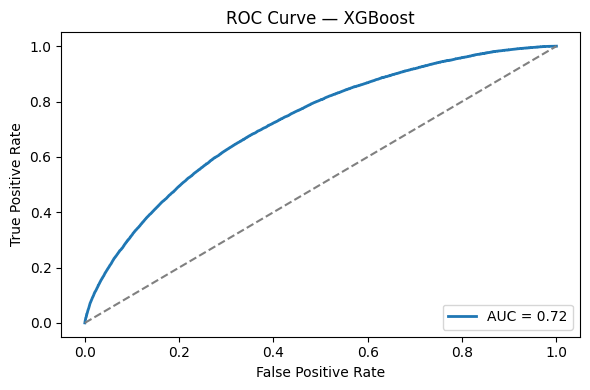

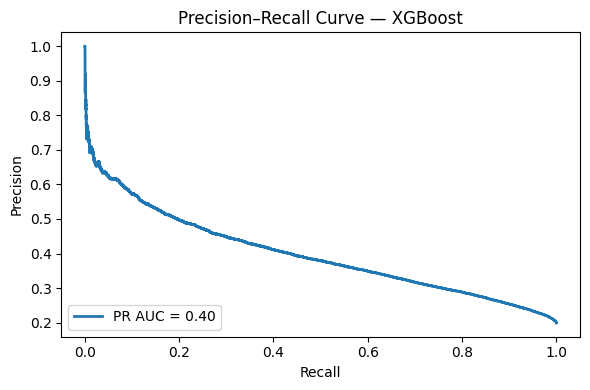

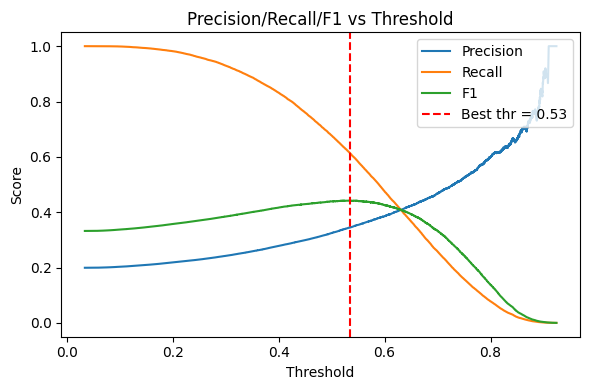

In [10]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve — XGBoost'); plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Precision–Recall
plt.figure(figsize=(6,4))
plt.plot(rec, prec, lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve — XGBoost'); plt.legend(loc='lower left'); plt.tight_layout(); plt.show()

# Threshold sweep plot (optional nice touch)
plt.figure(figsize=(6,4))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1],  label='Recall')
plt.plot(thr, f1[:-1],   label='F1')
plt.axvline(best_thr, color='red', linestyle='--', label=f'Best thr = {best_thr:.2f}')
plt.xlabel('Threshold'); plt.ylabel('Score')
plt.title('Precision/Recall/F1 vs Threshold'); plt.legend(); plt.tight_layout(); plt.show()
